# **Model Training**

In [ ]:
!unzip '/content/drive/MyDrive/augmented_training_data.zip'
!unzip '/content/drive/MyDrive/Copy of testing_set.zip'

In [3]:
# importing libraries
import os
import glob
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception, preprocess_input  
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Required Parameters
train_path = "/content/content/content/training_set"
test_path = "/content/content/testing_set"
no_of_frames = 1150
batch_size = 64
n_classes = 50
patience = 2
epochs = 5 
stime = int(time.time())
categories = os.listdir(train_path)

In [ ]:
def class_counter(DIR):
    classes = os.listdir(DIR)
    class_count = {}

    for each_class in classes:
        path = os.path.join(DIR, each_class)
        images_count = len(os.listdir(path))
        class_count[each_class] = images_count

    return class_count

In [ ]:
train_class_count = class_counter('/content/content/content/training_set')
test_class_count = class_counter('/content/content/testing_set')

<Axes: xlabel='class', ylabel='count'>

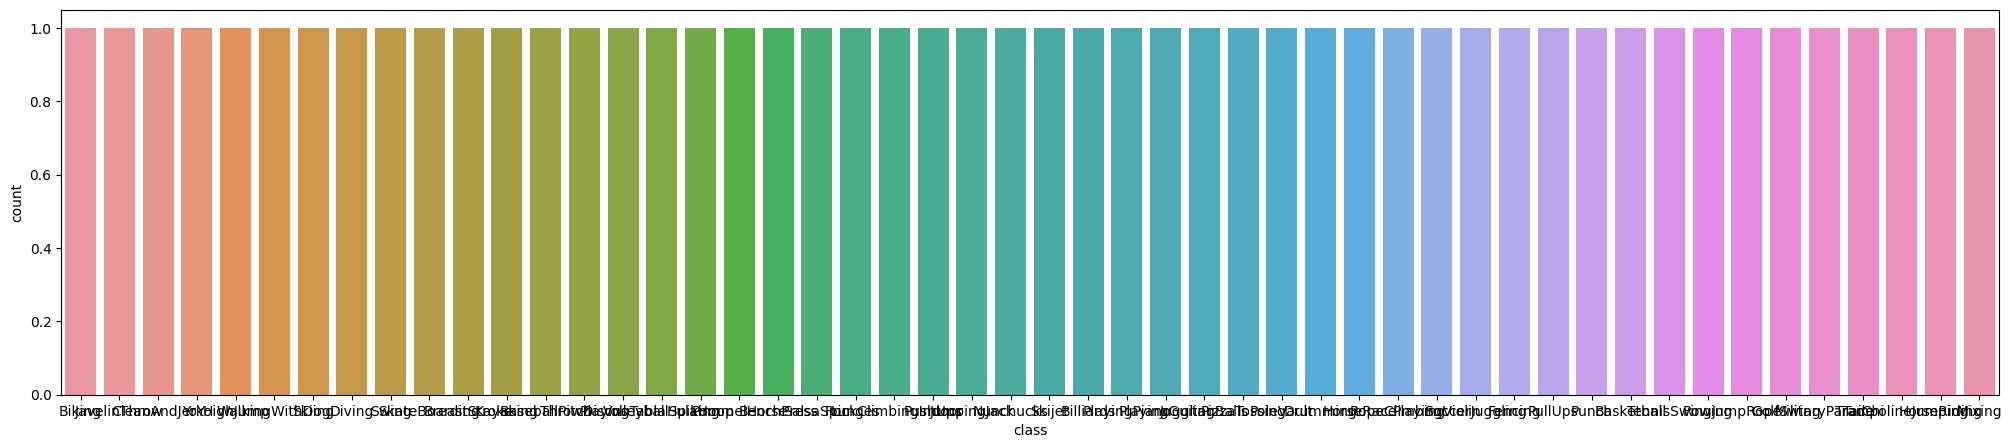

In [ ]:
train_df = pd.DataFrame(list(train_class_count.items()), columns=['class', 'count'])

plt.figure(figsize=(25, 5))
sns.countplot(x='class', data=train_df)

In [ ]:
categories.sort()
print(categories)

['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


In [ ]:
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
preds = Dense(n_classes, activation = 'softmax')(x)

In [ ]:
model = Model(inputs = base_model.input, outputs = preds)

In [ ]:
# Model Summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

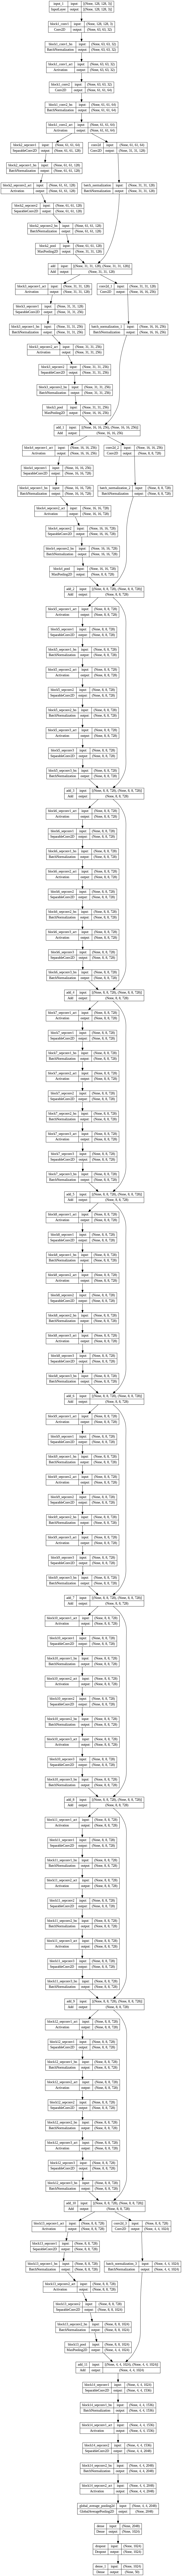

In [ ]:
plot_model(model, to_file='xception.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Setting each layer as trainable
for layer in model.layers:
    layer.trainable = True

In [ ]:
# Defining Image Data Generators
train_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.4)
test_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagenerator.flow_from_directory(train_path,
                                                          target_size = (128, 128),
                                                          color_mode = 'rgb',
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical',
                                                          subset = 'training',
                                                          shuffle = True)

validation_generator = train_datagenerator.flow_from_directory(train_path,
                                                               target_size = (128, 128),
                                                               color_mode = 'rgb',
                                                               batch_size = batch_size,
                                                               class_mode = 'categorical',
                                                               subset = 'validation')

test_generator = test_datagenerator.flow_from_directory(test_path,
                                                        target_size = (128, 128),
                                                        color_mode = 'rgb',
                                                        class_mode = 'categorical')

Found 33000 images belonging to 50 classes.
Found 22000 images belonging to 50 classes.
Found 7500 images belonging to 50 classes.


In [ ]:
print(train_generator.class_indices)

{'BaseballPitch': 0, 'Basketball': 1, 'BenchPress': 2, 'Biking': 3, 'Billiards': 4, 'BreastStroke': 5, 'CleanAndJerk': 6, 'Diving': 7, 'Drumming': 8, 'Fencing': 9, 'GolfSwing': 10, 'HighJump': 11, 'HorseRace': 12, 'HorseRiding': 13, 'HulaHoop': 14, 'JavelinThrow': 15, 'JugglingBalls': 16, 'JumpRope': 17, 'JumpingJack': 18, 'Kayaking': 19, 'Lunges': 20, 'MilitaryParade': 21, 'Mixing': 22, 'Nunchucks': 23, 'PizzaTossing': 24, 'PlayingGuitar': 25, 'PlayingPiano': 26, 'PlayingTabla': 27, 'PlayingViolin': 28, 'PoleVault': 29, 'PommelHorse': 30, 'PullUps': 31, 'Punch': 32, 'PushUps': 33, 'RockClimbingIndoor': 34, 'RopeClimbing': 35, 'Rowing': 36, 'SalsaSpin': 37, 'SkateBoarding': 38, 'Skiing': 39, 'Skijet': 40, 'SoccerJuggling': 41, 'Swing': 42, 'TaiChi': 43, 'TennisSwing': 44, 'ThrowDiscus': 45, 'TrampolineJumping': 46, 'VolleyballSpiking': 47, 'WalkingWithDog': 48, 'YoYo': 49}


In [4]:
def get_f1_score(y_true, y_pred): 
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon()) 
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [5]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),  
    tf.keras.metrics.AUC(name='auc'),
    get_f1_score
]

In [ ]:
# Compiling the Model
model.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = METRICS)

In [ ]:
# Training the Model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs)

Epoch 1/5
516/516 [==============================] - 265s 475ms/step - loss: 3.5327 - accuracy: 0.9806 - precision: 0.9544 - recall: 0.0336 - auc: 0.6901 - get_f1_score: 0.0626 - val_loss: 2.9433 - val_accuracy: 0.9822 - val_precision: 0.9799 - val_recall: 0.1106 - val_auc: 0.8376 - val_get_f1_score: 0.1966
Epoch 2/5
516/516 [==============================] - 209s 405ms/step - loss: 2.3623 - accuracy: 0.9840 - precision: 0.9678 - recall: 0.2078 - auc: 0.9147 - get_f1_score: 0.3351 - val_loss: 1.6256 - val_accuracy: 0.9869 - val_precision: 0.9702 - val_recall: 0.3554 - val_auc: 0.9698 - val_get_f1_score: 0.5175
Epoch 3/5
516/516 [==============================] - 237s 459ms/step - loss: 1.1737 - accuracy: 0.9895 - precision: 0.9623 - recall: 0.4924 - auc: 0.9842 - get_f1_score: 0.6448 - val_loss: 0.8871 - val_accuracy: 0.9916 - val_precision: 0.9526 - val_recall: 0.6101 - val_auc: 0.9889 - val_get_f1_score: 0.7424
Epoch 4/5
516/516 [==============================] - 201s 390ms/step - lo

In [ ]:
def train_val_plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (30,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['Training', 'Validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['Training', 'Validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['Training', 'Validation'])
    plt.show()

In [ ]:
model_history = pd.read_csv('/content/drive/MyDrive/DL_Project_Data/Xception_history.csv')
model_history.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
model_history

,loss,accuracy,precision,recall,auc,get_f1_score,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_get_f1_score
0,3.532750,0.980641,0.954428,0.033636,0.690056,0.062613,2.943281,0.982167,0.979871,0.110636,0.837623,0.196595
1,2.362307,0.984018,0.967819,0.207788,0.914723,0.335068,1.625649,0.986890,0.970220,0.355409,0.969820,0.517479
2,1.173689,0.989462,0.962333,0.492394,0.984158,0.644835,0.887098,0.991595,0.952590,0.610091,0.988889,0.742391
3,0.608796,0.993982,0.958977,0.730333,0.995379,0.827565,0.620684,0.993972,0.942834,0.743682,0.992385,0.830611
4,0.356131,0.996407,0.967661,0.848697,0.998194,0.903719,0.500431,0.995048,0.938769,0.804909,0.993729,0.866085


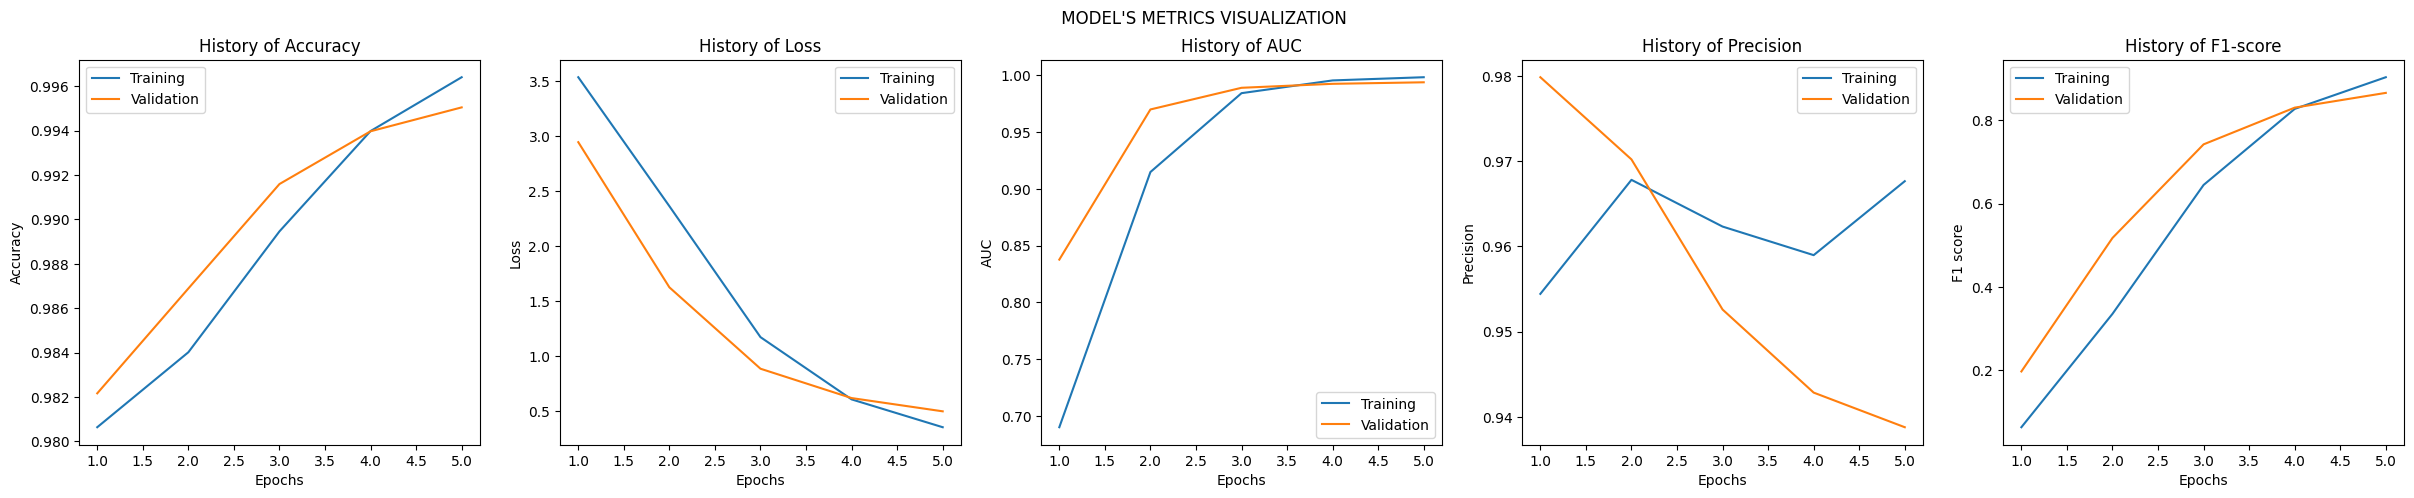

In [ ]:
train_val_plot(
    model_history['accuracy'], model_history['val_accuracy'],
    model_history['loss'], model_history['val_loss'],
    model_history['auc'], model_history['val_auc'],
    model_history['precision'], model_history['val_precision'],
    model_history['get_f1_score'], model_history['val_get_f1_score'],
)

In [ ]:
# Evaluating Model's Performance
history2 = model.evaluate(test_generator)

235/235 [==============================] - 20s 81ms/step - loss: 0.3239 - accuracy: 0.9967 - precision: 0.9645 - recall: 0.8651 - auc: 0.9978 - get_f1_score: 0.9114


In [ ]:
model.save('/content/drive/MyDrive/DL_Project_Data/Xception.h5')

# **GradCam Implementation**

In [28]:
from tensorflow import keras
from IPython.display import Image, display
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image as PIL_Loader
import matplotlib.pyplot as plt
import keras.utils as image
import matplotlib.cm as cm
import warnings

warnings.filterwarnings('ignore')

In [8]:
model = keras.models.load_model('/content/drive/MyDrive/DL_Project_Data/Xception.h5', custom_objects={'get_f1_score': get_f1_score})

In [35]:
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
image_size = (128, 128)

In [27]:
image_path = '/content/content/testing_set/BaseballPitch/frame_1180.jpg'

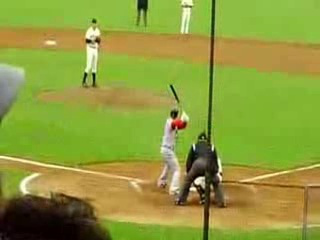

In [33]:
image = PIL_Loader.open(image_path)
image

In [16]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

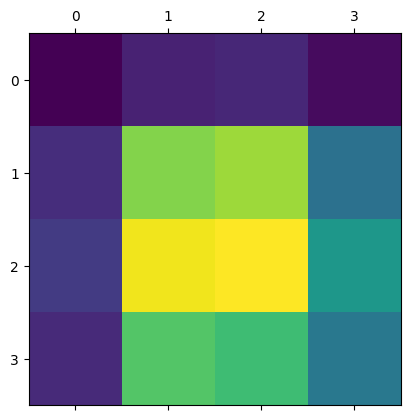

In [36]:
img_array = preprocess_input(get_img_array(image_path, size=image_size))
model.layers[-1].activation = None

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

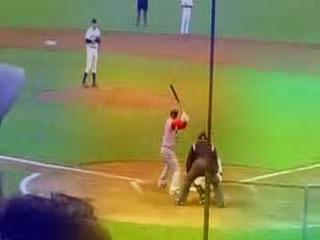

In [37]:
save_and_display_gradcam(image_path, heatmap)

In [39]:
np.argmax(model.predict(img_array))

1/1 [==============================] - 0s 131ms/step


0